In [36]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
data = loadmat('allFaces.mat')

In [33]:
faces = data['faces'][:,:64]
w = int(data['n'][0])
h = int(data['m'][0])

In [35]:
faces.shape

(32256, 64)

In [146]:
def rPCA(D, lam=1e-2, tol=1e-3):
    m,n = D.shape
    
    Y = D.copy()
    norm2 = np.linalg.norm(Y, 2)
    normInf = Y.max()/lam
    
    Y = Y / normInf
    
    A_hat = np.zeros((m,n))
    E_hat = np.zeros_like(A_hat)
    
    mu = 1.25 / norm2
    mu_bar = mu*1e7
    rho = 1.5
    d_norm = np.linalg.norm(D, 'fro')
    iter_ = 0
    total_svd = 0
    converged = False
    while not converged:
        iter_ += 1
        X = D - A_hat + Y/mu
        # temp_T = D-A_hat+ Y/mu
        # Soft threshold on scalars (this implementation matches slides better)
        E_hat = np.sign(X)*np.maximum(np.abs(X)-lam/mu, 0)
        # Equivalent, as per MATLAB code
        # E_hat = np.maximum(X-lam/mu,0)
        # E_hat = E_hat+np.minimum(X+lam/mu,0)
        # Soft threshold SVD
        u, s, vh = np.linalg.svd(D-E_hat+Y/mu,full_matrices=False)
        svp = (s > 1/mu).sum()
        A_hat = (u[:, :svp]*(s[:svp]-1/mu))@vh[:svp]  # reconstruct
        total_svd += 1
        Z = D-A_hat-E_hat  # Constraint violation
        Y = Y + mu*Z  # update lagragian multipliers
        mu = min(mu*rho, mu_bar)  # mu is augmented penalty coefficient
        # % stop Criterion
        stopCriterion = np.linalg.norm(Z, 'fro') / d_norm
        if stopCriterion < tol:
            converged = True
            
    return A_hat, E_hat

In [147]:
a,e = rPCA(faces)

In [167]:
def plotit(main, low, sparse, cols, figsize):
    plt.subplots(nrows=len(cols), ncols=3, figsize=figsize)
    for pos,col in enumerate(cols):
        base = pos * 3
        plt.subplot(len(cols), 3, base+1)
        plt.imshow(main[:,pos].reshape((h,w)).T, cmap='gray', vmin=0, vmax=255)
        plt.axis('off')
        plt.title('Original')
        
        plt.subplot(len(cols), 3, base+2)
        plt.imshow(low[:,pos].reshape((h,w)).T, cmap='gray')
        plt.axis('off')
        plt.title('Low Rank')
        
        plt.subplot(len(cols), 3, base+3)
        plt.imshow(sparse[:,pos].reshape((h,w)).T, cmap='gray')
        plt.axis('off')
        plt.title('Sparse')
    plt.show()
        

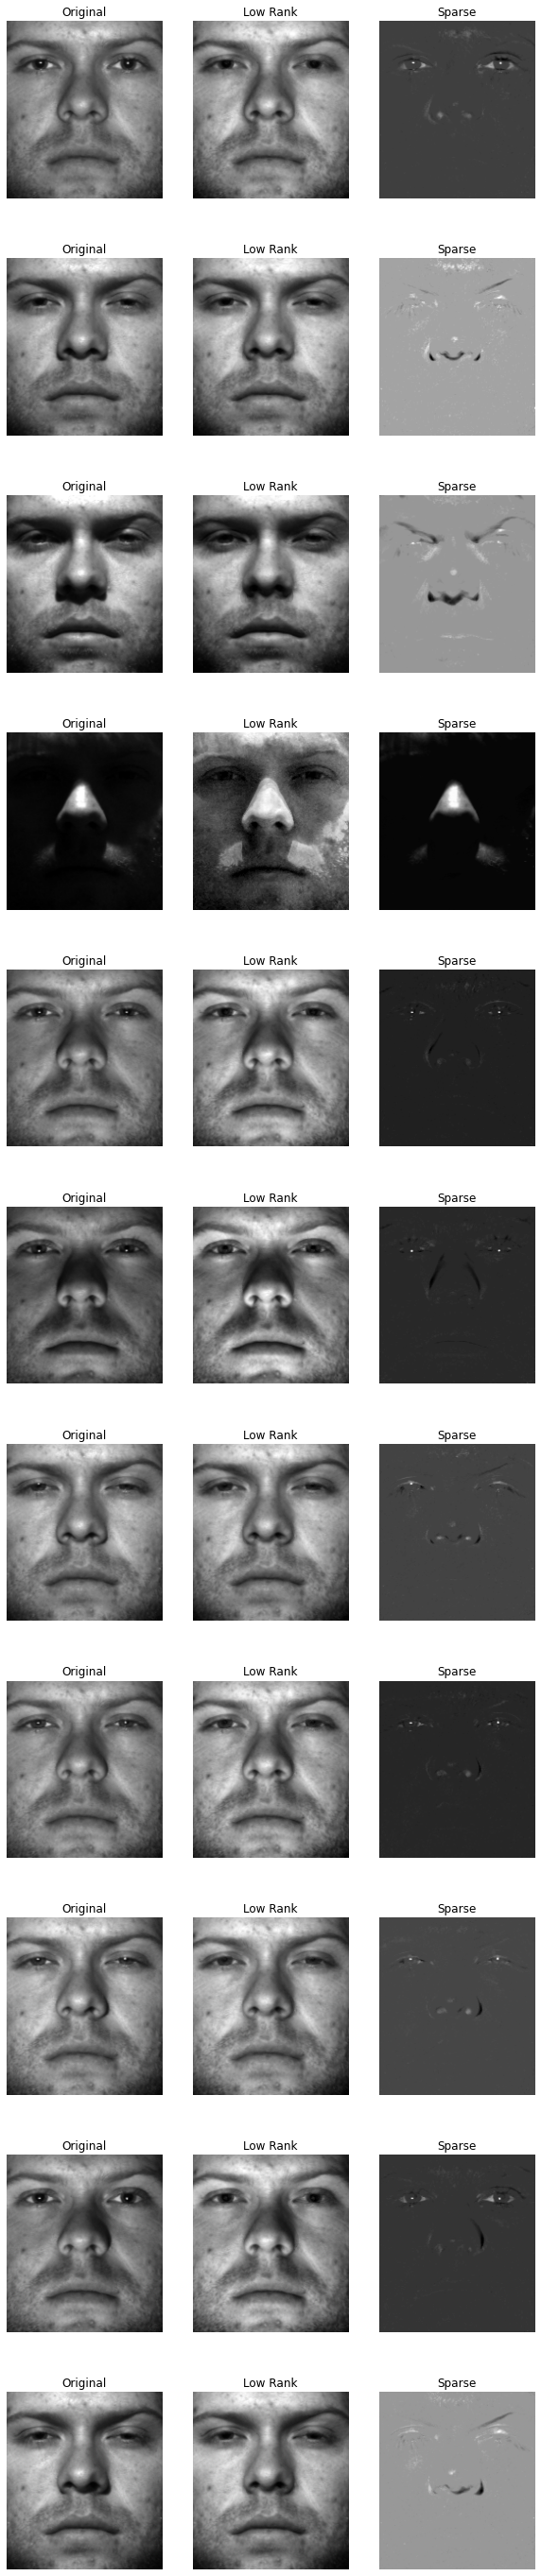

In [168]:
plotit(faces,a,e,cols=(3,4,14,15,17,18,19,20,21,32,43), figsize=(10,50))